In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import FrameDataset

[Dataset Initialization - val] Class counts: Counter({'procedural': 275, 'nonprocedural': 246})


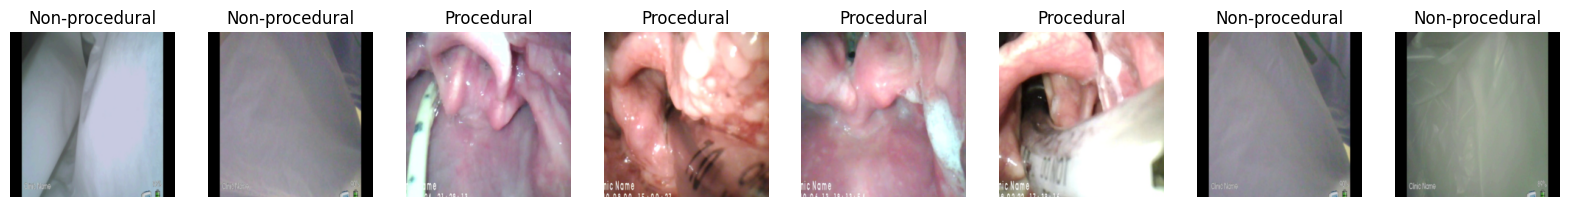

In [2]:

val_dataset = FrameDataset(img_dir='../data', split='val')
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

images, labels = next(iter(val_loader))

fig, axs = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title('Procedural' if labels[i]==1 else 'Non-procedural')
    axs[i].axis('off')
plt.show()


[Dataset Initialization - train] Class counts: Counter({'procedural': 1236, 'nonprocedural': 1132})


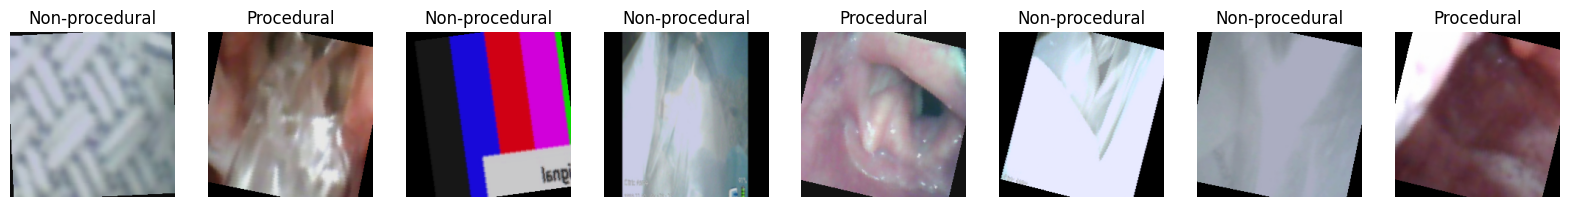

In [3]:

train_dataset = FrameDataset(img_dir='../data', split='train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

images, labels = next(iter(train_loader))

fig, axs = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title('Procedural' if labels[i]==1 else 'Non-procedural')
    axs[i].axis('off')
plt.show()


[Dataset Initialization - test] Class counts: Counter({'nonprocedural': 323, 'procedural': 252})


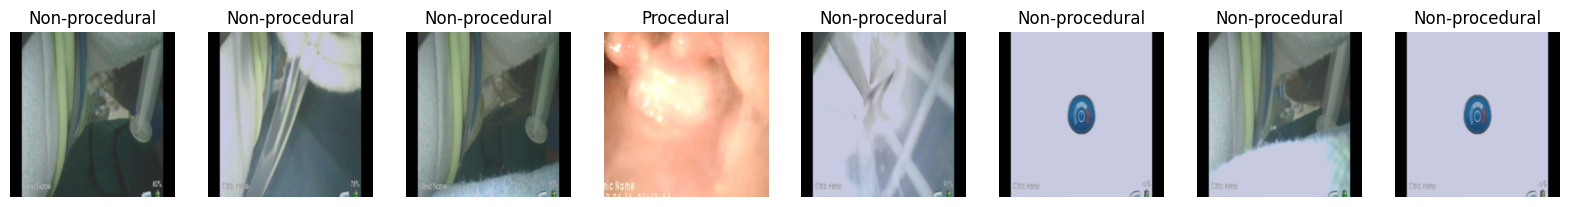

In [4]:

test_dataset = FrameDataset(img_dir='../data', split='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

images, labels = next(iter(test_loader))

fig, axs = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title('Procedural' if labels[i]==1 else 'Non-procedural')
    axs[i].axis('off')
plt.show()


In [2]:
# inference.py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from model import get_model
from dataset import FrameDataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/data/VirtualAging/users/ghoyer/conda/envs/autolabel2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Dataset Initialization - test] Class counts: Counter({'nonprocedural': 323, 'procedural': 252})
Classification Report:
                precision    recall  f1-score   support

Non-Procedural       1.00      1.00      1.00       323
    Procedural       1.00      1.00      1.00       252

      accuracy                           1.00       575
     macro avg       1.00      1.00      1.00       575
  weighted avg       1.00      1.00      1.00       575



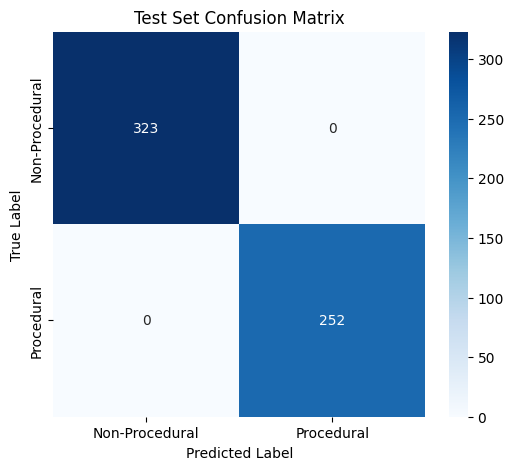

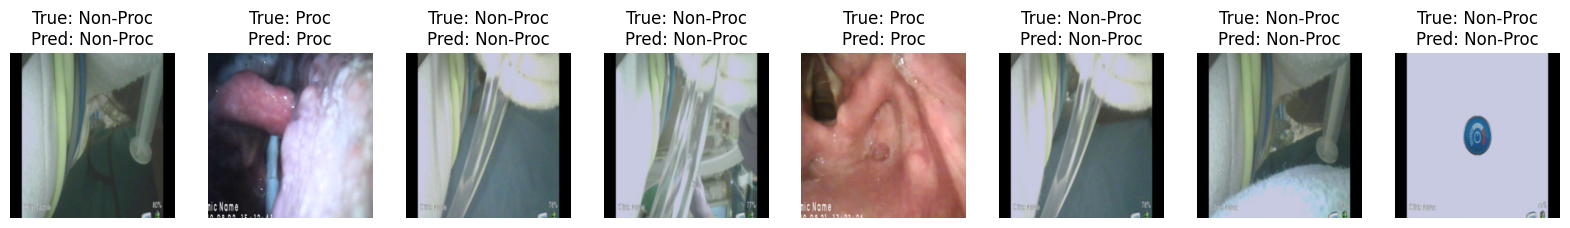

In [7]:


# Load model
model = get_model().to(device)
# model.load_state_dict(torch.load('../outputs/checkpoints/model_epoch_10_converted.pt', map_location=device))
# model.load_state_dict(torch.load('../outputs/checkpoints/model_epoch_10.pt', map_location=device))

state_dict = torch.load('../outputs/checkpoints/model_epoch_10.pt', map_location=device)
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.eval()

# Define transforms (should match dataset.py)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load test dataset and DataLoader
test_dataset = FrameDataset(img_dir='../data', split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)# False)

# Run inference on test data
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non-Procedural', 'Procedural']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Procedural', 'Procedural'], yticklabels=['Non-Procedural', 'Procedural'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Set Confusion Matrix')
plt.show()

# Visualization of predictions on random batch
images, labels = next(iter(test_loader))
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig, axs = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title(f'True: {"Proc" if labels[i]==1 else "Non-Proc"}\nPred: {"Proc" if preds[i]==1 else "Non-Proc"}')
    axs[i].axis('off')
plt.show()